In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
from torch.utils.tensorboard import SummaryWriter

In [2]:
writer = SummaryWriter('runs/cifar_experiment_1')
writer.close()

# Data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship  frog  plane ship 


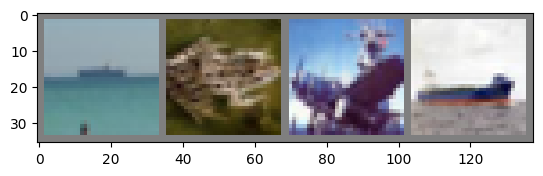

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
writer.add_image('four_cifar_images', img_grid)

# Training

In [5]:
model = resnet18(weights=None)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(classes))
writer.add_graph(model, images)

In [6]:
class TrainerConfig:
    loss: str = "CrossEntropy"
    optimizer: str = "SGD"
    lr: float = 0.001
    momentum: float = 0.9
    n_epoch: int = 10
    device = "cuda:0"

In [7]:
class Trainer:
    def __init__(self, config, model, train_loader, eval_loader, writer):
        self.config = config
        self.model = model.to(device=config.device)
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.epoch = 0
        self.n_epoch = config.n_epoch
        self.device = config.device
        self.writer = writer

        if config.loss == "CrossEntropy":
            self.loss = nn.CrossEntropyLoss()
        else:
            raise NotImplementedError()
        
        if config.optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=config.lr, momentum=config.momentum)
        else:
            raise NotImplementedError()

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for i, data in enumerate(self.train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device=self.device), labels.to(device=self.device)
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.loss(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f"epoch {self.epoch + ((i + 1) / len(self.train_loader)):.3f} loss {running_loss / (i + 1):.5f}")
                self.writer.add_scalar('training_loss', running_loss / (i + 1), self.epoch * len(self.train_loader) + i)
                self.plot_preds_to_tb(inputs, labels, i)
    
    def eval_epoch(self):
        self.model.eval()
        running_loss = 0.0
        running_correct = 0
        with torch.no_grad():
            for i, data in enumerate(self.eval_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device=self.device), labels.to(device=self.device)

                outputs = self.model(inputs)

                running_correct += (outputs.argmax(dim=1) == labels).sum().item()
                running_loss += self.loss(outputs, labels).item()
        
        loss = running_loss / len(self.eval_loader)
        accuracy = running_correct / len(self.eval_loader.dataset)
        print(f"eval epoch {self.epoch} loss {loss:.5f} accuracy {accuracy:.5f}")
        self.writer.add_scalar('eval_loss', loss, (self.epoch + 1) * len(self.train_loader))
        self.writer.add_scalar('eval_acc', accuracy, (self.epoch + 1) * len(self.train_loader))
    
    def train(self):
        for epoch in range(self.n_epoch):
            self.epoch = epoch
            print(f"----- starting epoch {epoch} -----")
            self.train_epoch()
            self.eval_epoch()

    def plot_preds_to_tb(self, inputs, labels, i):
        def images_to_probs(net, images):
            '''
            Generates predictions and corresponding probabilities from a trained
            network and a list of images
            '''
            output = net(images)
            # convert output probabilities to predicted class
            _, preds_tensor = torch.max(output, 1)
            preds = np.squeeze(preds_tensor.cpu().numpy())
            return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


        def plot_classes_preds(net, images, labels):
            '''
            Generates matplotlib Figure using a trained network, along with images
            and labels from a batch, that shows the network's top prediction along
            with its probability, alongside the actual label, coloring this
            information based on whether the prediction was correct or not.
            Uses the "images_to_probs" function.
            '''
            preds, probs = images_to_probs(net, images)
            images, labels = images.cpu(), labels.cpu()
            # plot the images in the batch, along with predicted and true labels
            fig = plt.figure(figsize=(16, 4))
            for idx in range(len(images)):
                ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
                imshow(images[idx])
                ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
                    classes[preds[idx]],
                    probs[idx] * 100.0,
                    classes[labels[idx]]),
                            color=("green" if preds[idx]==labels[idx].item() else "red"))
            fig.show()
            return fig
        
        self.writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(self.model, inputs, labels),
                            global_step=self.epoch * len(trainloader) + i)

In [8]:
config = TrainerConfig()
trainer = Trainer(config, model, trainloader, testloader, writer)
trainer.train()

----- starting epoch 0 -----
epoch 0.160 loss 2.34365
epoch 0.320 loss 2.20738
epoch 0.480 loss 2.12132
epoch 0.640 loss 2.05544
epoch 0.800 loss 1.99929
epoch 0.960 loss 1.94906
eval epoch 0 loss 1.47427 accuracy 0.47120
----- starting epoch 1 -----
epoch 1.160 loss 1.64973
epoch 1.320 loss 1.61558
epoch 1.480 loss 1.58198
epoch 1.640 loss 1.54960
epoch 1.800 loss 1.52422
epoch 1.960 loss 1.50535
eval epoch 1 loss 1.19184 accuracy 0.58100
----- starting epoch 2 -----
epoch 2.160 loss 1.35462
epoch 2.320 loss 1.33790
epoch 2.480 loss 1.32929
epoch 2.640 loss 1.30997
epoch 2.800 loss 1.29371
epoch 2.960 loss 1.28103
eval epoch 2 loss 1.10282 accuracy 0.61320
----- starting epoch 3 -----
epoch 3.160 loss 1.15995
epoch 3.320 loss 1.15463
epoch 3.480 loss 1.13946
epoch 3.640 loss 1.13684
epoch 3.800 loss 1.12719
epoch 3.960 loss 1.11356
eval epoch 3 loss 1.01323 accuracy 0.65480
----- starting epoch 4 -----
epoch 4.160 loss 1.00004
epoch 4.320 loss 0.99670
epoch 4.480 loss 1.00619
epoch 4.